# Random Forest

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest

In [2]:
#input of train data
data = pd.read_csv("trainset_2168.csv")

In [3]:
df = pd.DataFrame(data)
y= df.Target
X=df.drop('Target', axis=1)

In [4]:
cat_features=list(range(0,X.shape[1]))
#print(cat_features)

In [5]:
df.Target.value_counts()

Target
1    1718
0     450
Name: count, dtype: int64

In [6]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

In [7]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [8]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=3000,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',  # Use 'sqrt' instead of 'auto'
    bootstrap=True
)

# Transpose the data if necessary (if the samples are in columns)
# Ensure that the shapes of x_train and y_train are compatible
if x_train.shape[0] != y_train.shape[0]:
    x_train = x_train.T

# Fit the model with the corrected data
rf.fit(x_train, y_train)

# Calculate accuracy on the training set
acc_train = rf.score(x_train, y_train) * 100
print("Training Accuracy:", acc_train)


Training Accuracy: 90.12915129151291


<Figure size 4200x3000 with 0 Axes>

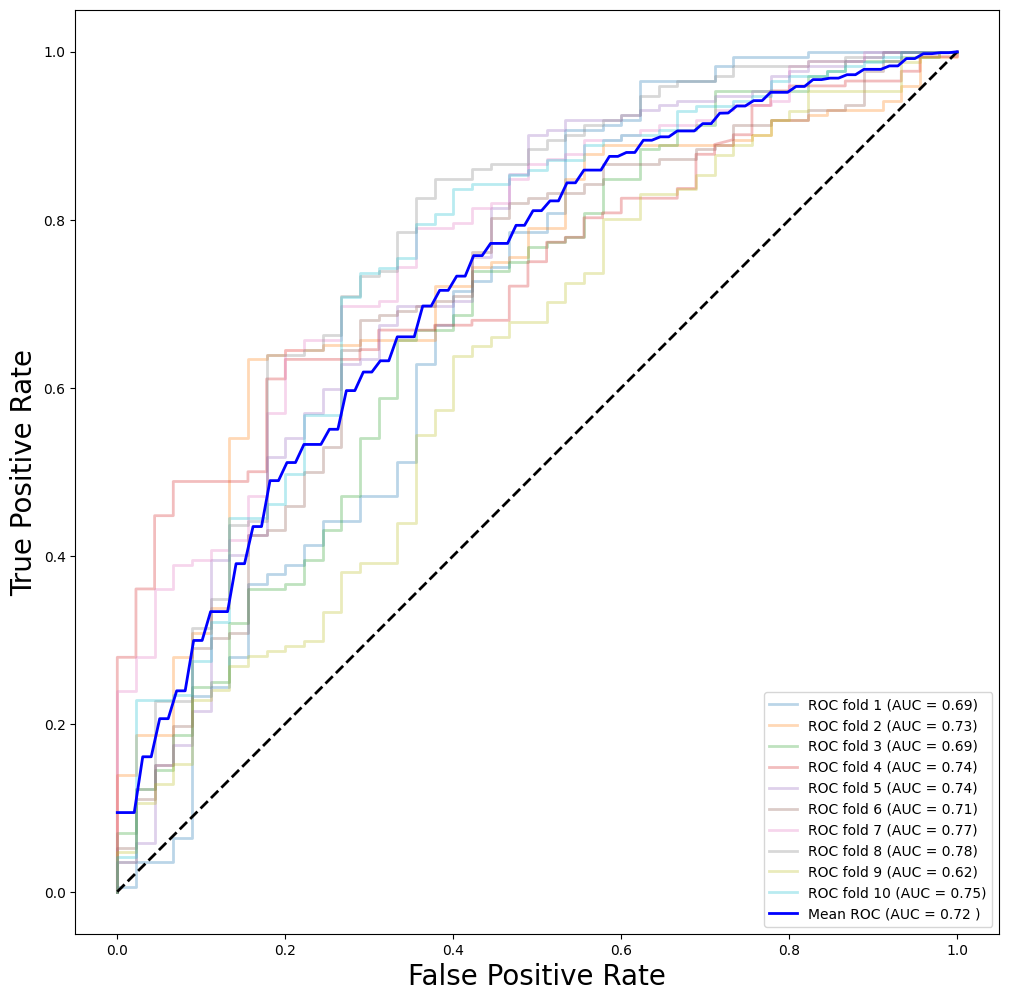

In [10]:
# K-fold cross validation

from sklearn.metrics import RocCurveDisplay
from numpy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = rf.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.savefig('k_fold_RF.png', dpi=600, bbox_inches='tight')
plt.show()

In [11]:
from sklearn.model_selection import cross_val_score, KFold

k_folds = 10  
# Initialize K-fold cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

cv_scores = cross_val_score(rf, x_train, y_train, cv=kf)

# Print the cross-validation scores
for fold, acc in enumerate(cv_scores, 1):
    print(f"Cross-validation Fold {fold} Accuracy: {acc * 100:.2f}%")

# Calculate and print the mean and standard deviation of cross-validation scores
print(f"\nMean Accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard Deviation: {cv_scores.std() * 100:.2f}%")

Cross-validation Fold 1 Accuracy: 80.65%
Cross-validation Fold 2 Accuracy: 78.34%
Cross-validation Fold 3 Accuracy: 76.04%
Cross-validation Fold 4 Accuracy: 85.71%
Cross-validation Fold 5 Accuracy: 77.88%
Cross-validation Fold 6 Accuracy: 73.27%
Cross-validation Fold 7 Accuracy: 81.11%
Cross-validation Fold 8 Accuracy: 86.64%
Cross-validation Fold 9 Accuracy: 83.33%
Cross-validation Fold 10 Accuracy: 81.94%

Mean Accuracy: 80.49%
Standard Deviation: 3.99%


# Test Set

In [12]:
#Read the validation Test set
v_test_data = pd.read_csv("external_set_624.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(624, 61)

In [13]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [14]:
# Test with hold-out test set
v_predictions = rf.predict(X_v_test_data)
v_acc_test = rf.score(X_v_test_data, Y_v_test_data)*100
print(v_acc_test)

95.67307692307693


In [15]:
# performance metrics to calculate
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:87.708
Sensitivity:0.970
Specificity:0.412
Balance accuracy:0.691
MCC: 0.489
AUC: 0.691
Brier_loss: 0.123
False Postive rate: 0.588
False Negative rate: 0.030
Precision: 0.892
Recall: 0.970
F1: 0.929
Kappa: 0.464


In [16]:
# confusion matrix
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.73      0.41      0.53        80
           1       0.89      0.97      0.93       400

    accuracy                           0.88       480
   macro avg       0.81      0.69      0.73       480
weighted avg       0.87      0.88      0.86       480



<Axes: xlabel='Predicted Value', ylabel='True Value'>

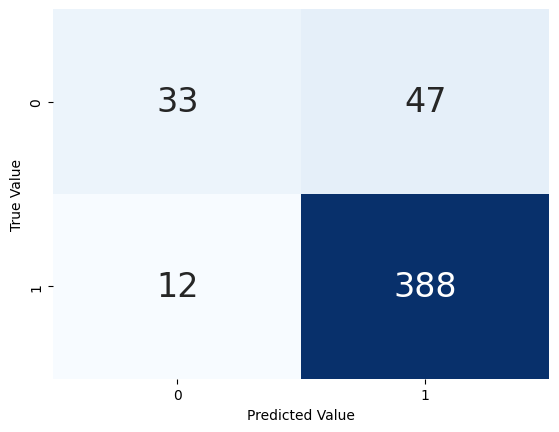

In [17]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [18]:
fig = cf_plt.get_figure()
fig.savefig("RF_Con_mat.png") 

In [15]:
m2= rf.predict_proba(X_v_test_data)
m2 = pd.DataFrame(m2)
m2.to_csv("External_RF_Probabs.csv")

In [21]:

m2_probs = rf.predict_proba(X_v_test_data)

# Convert probabilities to binary predictions
m2_binary = (m2_probs[:, 1] > 0.5).astype(int)

# Create a DataFrame with binary predictions
m2_binary_df = pd.DataFrame(m2_binary, columns=['Predicted_Class'])

# Save to CSV
m2_binary_df.to_csv("RF_Probabs_Binary.csv", index=False)

In [22]:
# ROC - AUC curve 
r_probs = [0 for _ in range(len(Y_v_test_data))]
rf_prob = rf.predict_proba(X_v_test_data)
rf_prob = rf_prob[:,1]

In [23]:
r_auc_score = roc_auc_score(Y_v_test_data, rf_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, rf_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.84725


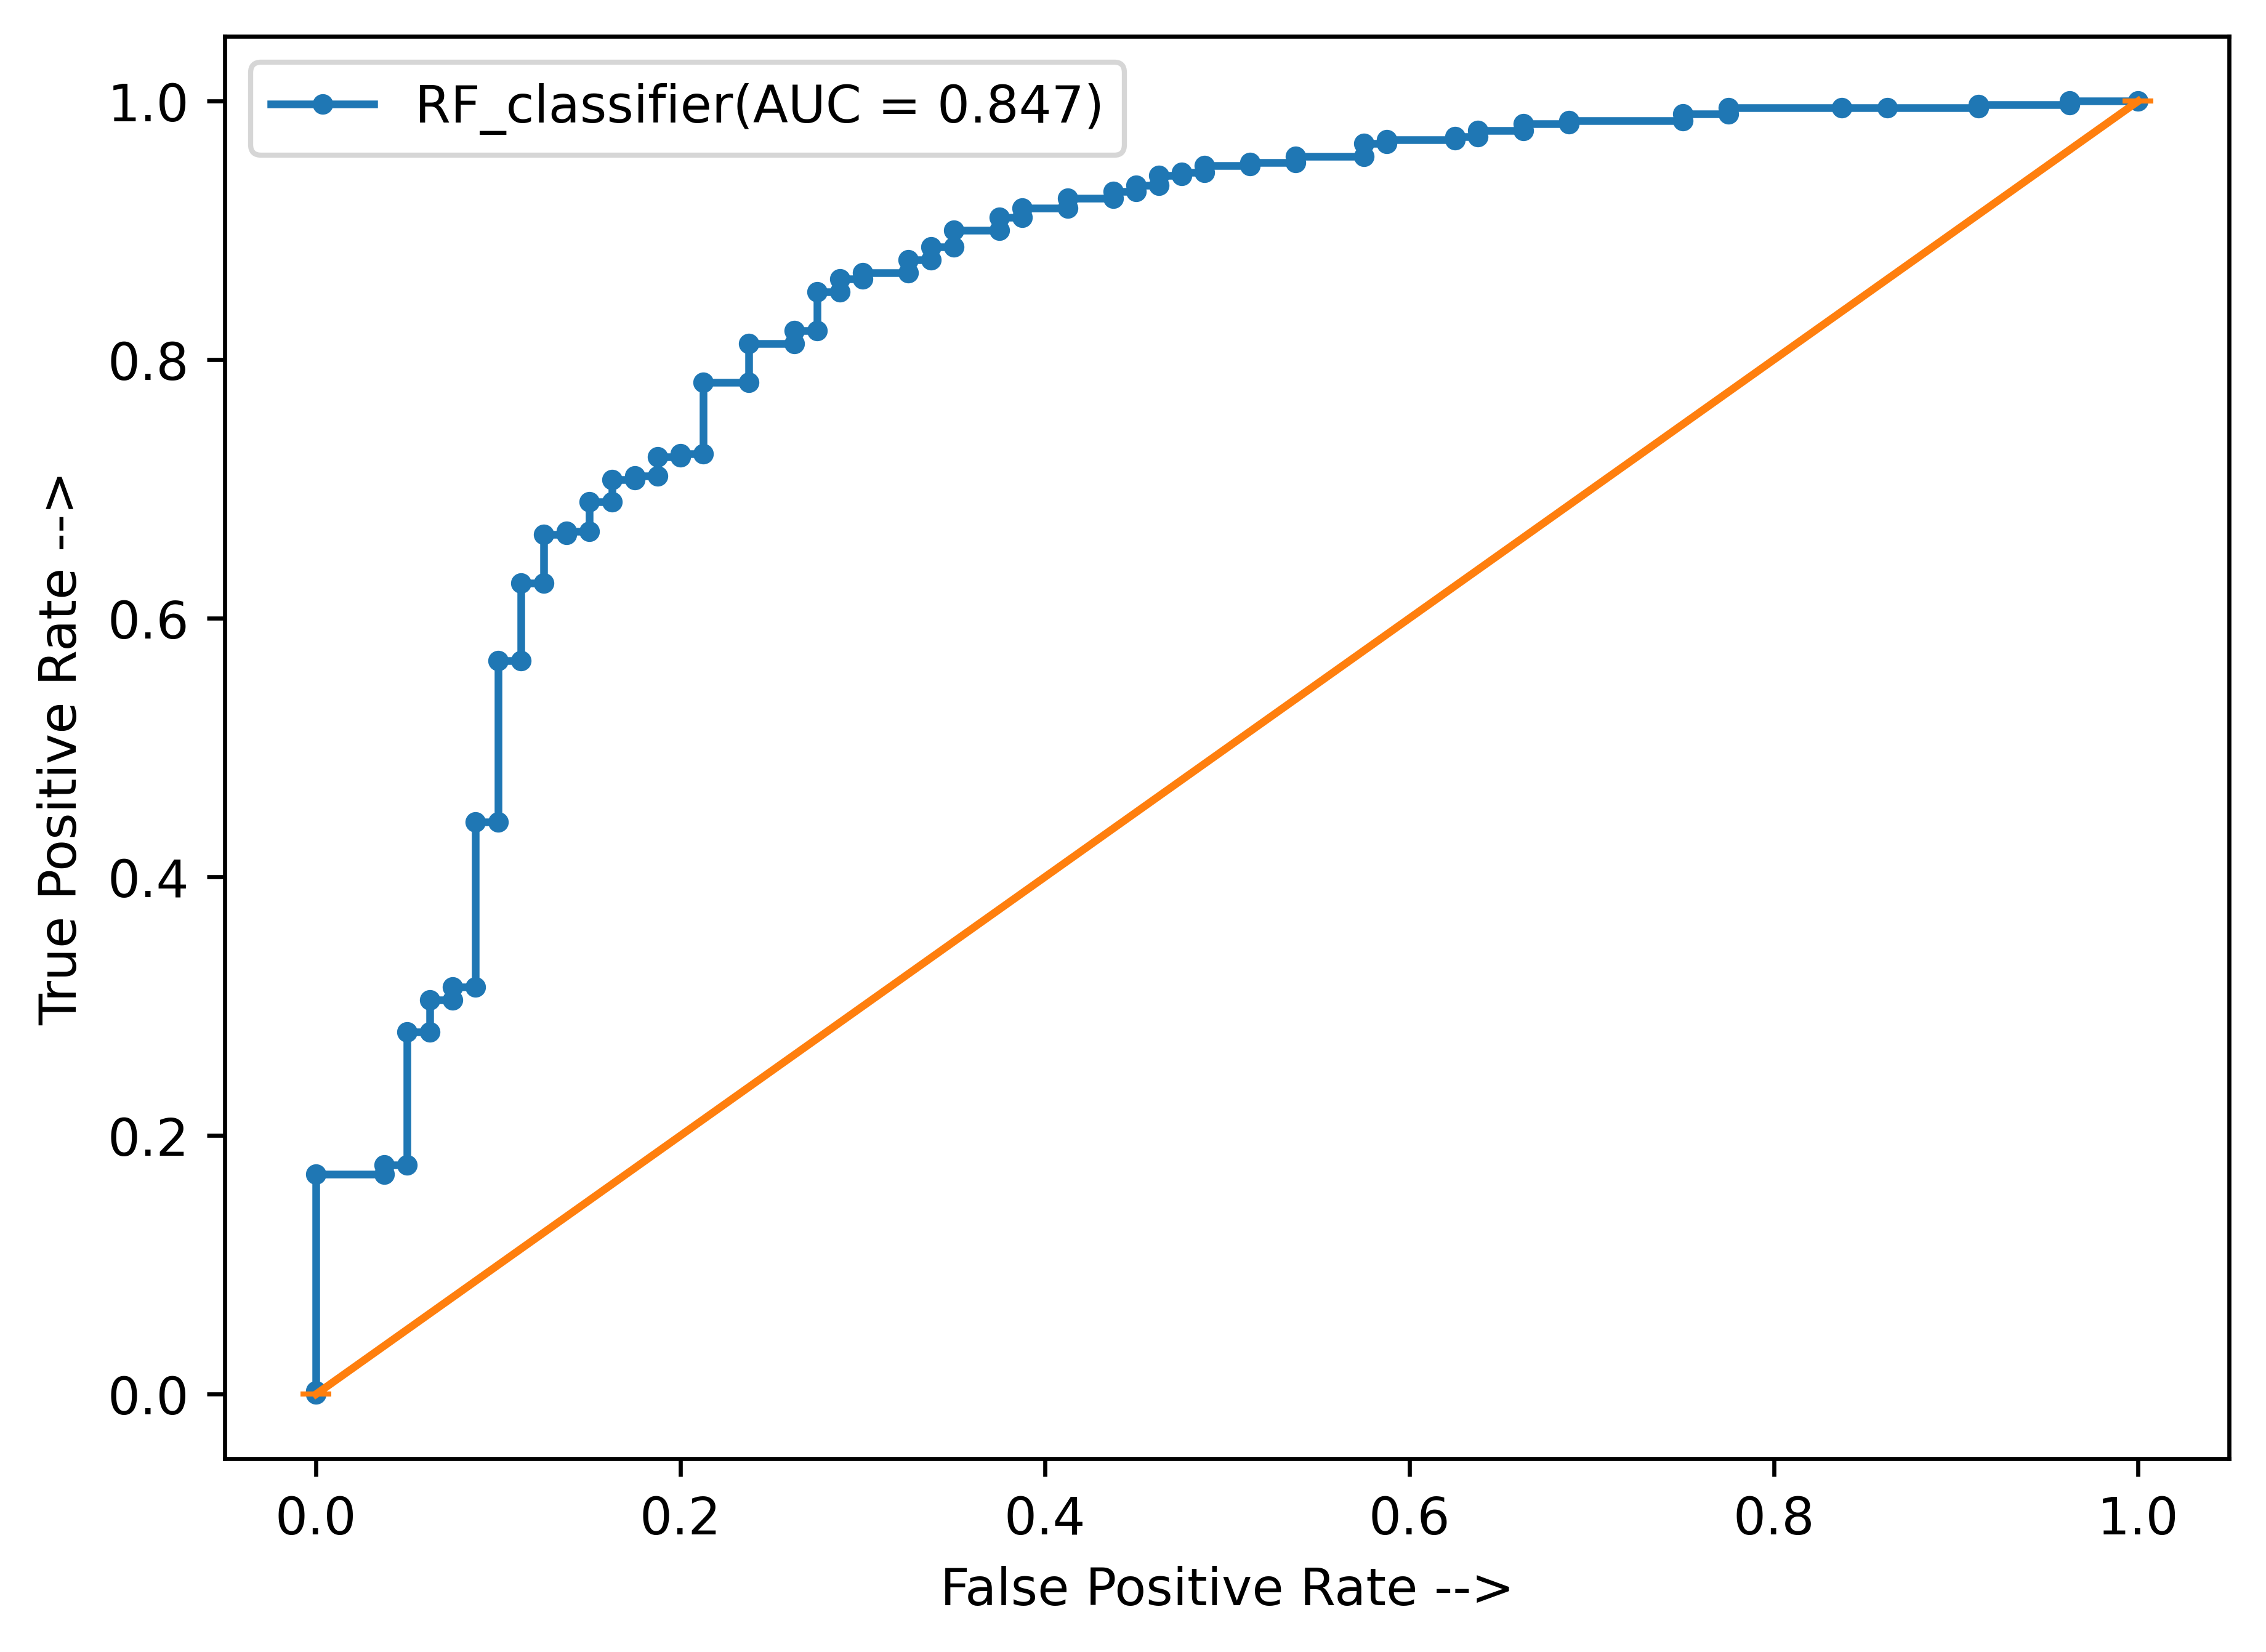

In [30]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='RF_classifier(AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.savefig('RF_AUC.png', dpi=600, bbox_inches='tight')# to save the image
plt.show()

PermutationExplainer explainer: 481it [48:59,  6.14s/it]                                                               


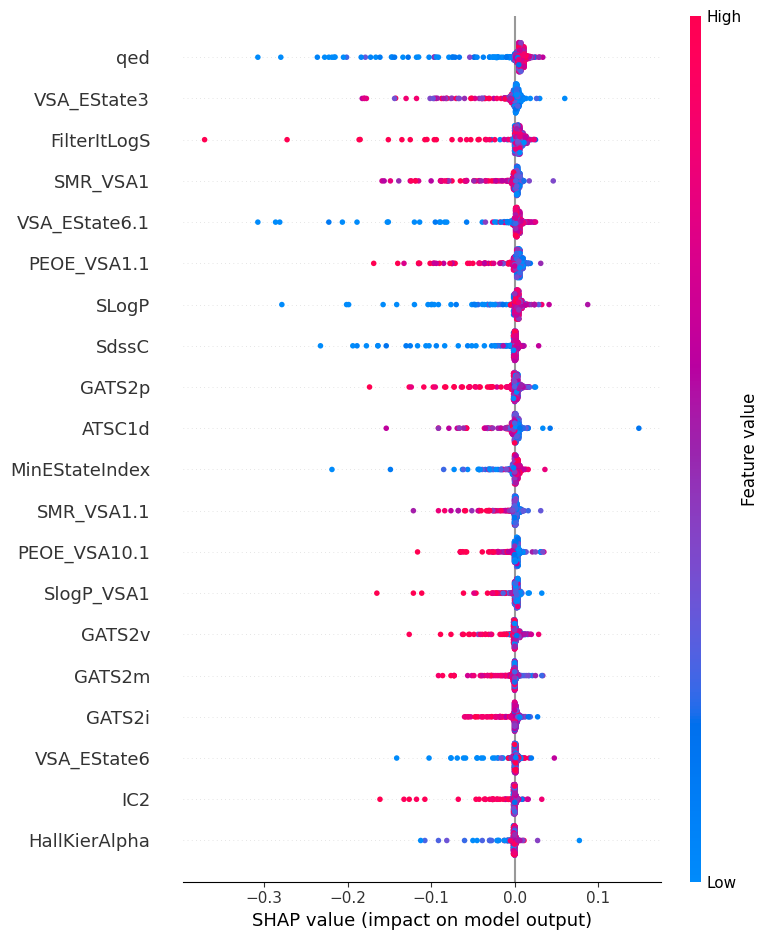

In [26]:
# Explainable AI
import shap

def model_predict(x_train):
    return rf.predict(x_train)

masker = shap.maskers.Independent(X_v_test_data)

explainer = shap.Explainer(model_predict, masker)

shap_values = explainer(X_v_test_data)

shap.summary_plot(shap_values, X_v_test_data, show=False)


In [33]:
import shap
import matplotlib.pyplot as plt

def model_predict(x_train):
    return rf.predict(x_train)

masker = shap.maskers.Independent(X_v_test_data)

explainer = shap.Explainer(model_predict, masker)

shap_values = explainer(X_v_test_data)

# Plot and save the SHAP summary plot
shap.summary_plot(shap_values, X_v_test_data, show=False)

# Save the plot to a file
plt.savefig('RF_shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.close()

PermutationExplainer explainer: 481it [50:05,  6.27s/it]                                                               


In [34]:
# Convert SHAP values to a DataFrame
shap_values_df = pd.DataFrame(shap_values.values, columns=X_v_test_data.columns)

# Save the SHAP values DataFrame to a CSV file
shap_values_df.to_csv('RF_shap_values.csv', index=False)